 Custom Impact Zone Loaded Successfully.
   - Center Point: (-0.16, 1.38)


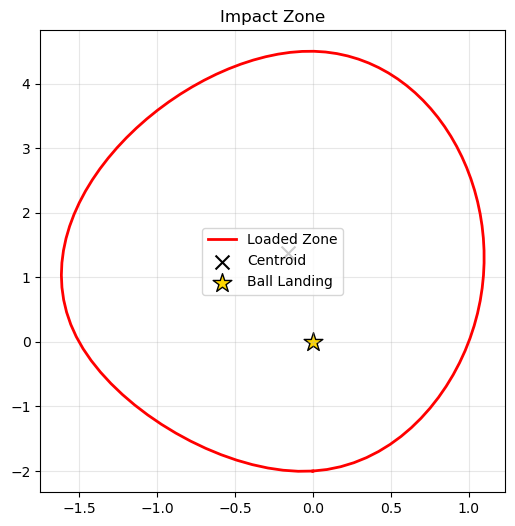

In [1]:
import pandas as pd
import numpy as np
import matplotlib.path as mpath
import matplotlib.pyplot as plt


# Load Saved Impact Zone

try:
    # 1. Load the CSV
    shape_df = pd.read_csv('impact_zone_shape_v1.csv')
    
    # 2. Extract Vertices
    zone_vertices = shape_df[['rel_x', 'rel_y']].values
    
    # 3. Create the Path Object (Crucial for "Is Inside" logic)
    impact_poly_path = mpath.Path(zone_vertices)
    
    # 4. Calculate the Centroid (Bullseye)
    # We use the mean of the smooth points to find the true center
    zone_center_x = shape_df['rel_x'].mean()
    zone_center_y = shape_df['rel_y'].mean()
    
    print(" Custom Impact Zone Loaded Successfully.")
    print(f"   - Center Point: ({zone_center_x:.2f}, {zone_center_y:.2f})")
    

# Plot Zone to confirm
    plt.figure(figsize=(6, 6))
    plt.plot(shape_df['rel_x'], shape_df['rel_y'], color='red', linewidth=2, label='Loaded Zone')
    plt.scatter(zone_center_x, zone_center_y, color='black', marker='x', s=100, label='Centroid')
    plt.scatter(0, 0, color='gold', marker='*', s=200, edgecolors='black', label='Ball Landing')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title("Impact Zone")
    plt.show()
    
except FileNotFoundError:
    print("Impact Zone not found")

In [2]:
import os

# STEP 1: Load Raw Data

# Dictionary to store everything
all_data = {
    'supplementary': None,
    'weeks': {}
}

# 1. Load Supplementary Data
if os.path.exists('supplementary_data.csv'):
    print("Loading supplementary_data.csv...")
    all_data['supplementary'] = pd.read_csv('supplementary_data.csv', low_memory=False)
    print(f" Supplementary Data Loaded: {len(all_data['supplementary']):,} rows")
else:
    print(" Error: 'supplementary_data.csv' not found.")

# 2. Load Tracking Data (Weeks 1-18)
weeks_range = range(1, 19)

for w in weeks_range:
    week_str = f"{w:02d}" # Converts 1 -> "01"
    input_file = f"input_2023_w{week_str}.csv"
    output_file = f"output_2023_w{week_str}.csv"
    
    # Check if files exist 
    if os.path.exists(input_file) and os.path.exists(output_file):
        print(f"\nFound Week {w} files. Loading...")
        try:
            # Load Input
            inp = pd.read_csv(input_file)
            # Load Output
            out = pd.read_csv(output_file)
            
            # Store in the dictionary
            all_data['weeks'][w] = {
                'input': inp,
                'output': out
            }
            print(f"   - Input: {len(inp):,} rows")
            print(f"   - Output: {len(out):,} rows")
            print(f" Week {w} Loaded.")
            
        except Exception as e:
            print(f" Error reading Week {w}: {e}")
    else:
        
        pass

# 3. Final Summary
print("\n" + "="*30)
print(f"DATA LOAD COMPLETE")
print(f"Weeks Loaded: {len(all_data['weeks'])}")
if all_data['supplementary'] is not None:
    print("Supplementary Data: Ready")
print("="*30)



Loading supplementary_data.csv...
 Supplementary Data Loaded: 18,009 rows

Found Week 1 files. Loading...
   - Input: 285,714 rows
   - Output: 32,088 rows
 Week 1 Loaded.

Found Week 2 files. Loading...
   - Input: 288,586 rows
   - Output: 32,180 rows
 Week 2 Loaded.

Found Week 3 files. Loading...
   - Input: 297,757 rows
   - Output: 36,080 rows
 Week 3 Loaded.

Found Week 4 files. Loading...
   - Input: 272,475 rows
   - Output: 30,147 rows
 Week 4 Loaded.

Found Week 5 files. Loading...
   - Input: 254,779 rows
   - Output: 29,319 rows
 Week 5 Loaded.

Found Week 6 files. Loading...
   - Input: 270,676 rows
   - Output: 31,162 rows
 Week 6 Loaded.

Found Week 7 files. Loading...
   - Input: 233,597 rows
   - Output: 27,443 rows
 Week 7 Loaded.

Found Week 8 files. Loading...
   - Input: 281,011 rows
   - Output: 33,017 rows
 Week 8 Loaded.

Found Week 9 files. Loading...
   - Input: 252,796 rows
   - Output: 28,291 rows
 Week 9 Loaded.

Found Week 10 files. Loading...
   - Input:

In [3]:
# STEP 2: Process data and transform coordinate system

def process_weeks(weeks_to_process):
    processed_dfs = []

    # 1. Load Supplementary Data 
    if os.path.exists('supplementary_data.csv'):
        supp_df = pd.read_csv('supplementary_data.csv')
        # Keep only relevant columns 
        if 'team_coverage_man_zone' in supp_df.columns:
             # Select join keys and the target column
             supp_cols = ['game_id', 'play_id', 'team_coverage_man_zone']
             supp_df = supp_df[supp_cols].drop_duplicates()
    else:
        supp_df = pd.DataFrame()

    for w in weeks_to_process:
        week_str = f"{w:02d}"
        input_file = f"input_2023_w{week_str}.csv"
        output_file = f"output_2023_w{week_str}.csv"

        if not os.path.exists(input_file) or not os.path.exists(output_file):
            print(f"Skipping Week {w} (Files missing)")
            continue
            
        print(f"Processing Week {w}...", end="\r") 
        
        # A. LOAD RAW DATA
        input_df = pd.read_csv(input_file)
        output_df = pd.read_csv(output_file)
        
        # B. Prepare Inputs
        possible_meta_cols = ['game_id', 'play_id', 'nfl_id', 'player_role', 'player_side', 'player_position', 'player_name']
        actual_meta_cols = [c for c in possible_meta_cols if c in input_df.columns]
        player_meta = input_df[actual_meta_cols].drop_duplicates()
        
        # 2. Snapshot at moment of throw
        physics_snapshot = input_df.sort_values('frame_id').groupby(['game_id', 'play_id', 'nfl_id']).tail(1)
        
        cols_to_grab = ['game_id', 'play_id', 'nfl_id']
        physics_vars = ['s', 'a', 'dir', 'o', 'num_frames_output']
        available_physics = [c for c in physics_vars if c in input_df.columns]
        
        physics_df = physics_snapshot[cols_to_grab + available_physics].copy()
        
        # Rename map 
        rename_map = {'s': 'start_s', 'a': 'start_a', 'dir': 'start_dir', 'o': 'start_o'}
        physics_df = physics_df.rename(columns=rename_map)
        
        # 3. Prepare  Y-axis
        if 'ball_land_x' in input_df.columns:
            ball_land = input_df[['game_id', 'play_id', 'ball_land_x', 'ball_land_y']].drop_duplicates()
        else:
            ball_land = pd.DataFrame(columns=['game_id', 'play_id', 'ball_land_x', 'ball_land_y'])

        if 'Passer' in input_df['player_role'].values:
            passer_rows = input_df[input_df['player_role'] == 'Passer']
            passer_locs = passer_rows.sort_values('frame_id').groupby(['game_id', 'play_id']).tail(1)
            passer_locs = passer_locs[['game_id', 'play_id', 'x', 'y']].rename(columns={'x': 'qb_x', 'y': 'qb_y'})
        else:
             passer_locs = pd.DataFrame(columns=['game_id', 'play_id', 'qb_x', 'qb_y'])

        # 4. Prepare X-Axis
        target_rows = input_df[input_df['player_role'] == 'Targeted Receiver']
        target_map = target_rows[['game_id', 'play_id', 'nfl_id']].drop_duplicates().rename(columns={'nfl_id': 'target_id'})
        # Merge everything
        merged_df = output_df.merge(player_meta, on=['game_id', 'play_id', 'nfl_id'], how='left')
        merged_df = merged_df.merge(physics_df, on=['game_id', 'play_id', 'nfl_id'], how='left')
        merged_df = merged_df.merge(ball_land, on=['game_id', 'play_id'], how='left')
        merged_df = merged_df.merge(passer_locs, on=['game_id', 'play_id'], how='inner') # Drops plays with no QB track
        
        if not supp_df.empty:
             merged_df = merged_df.merge(supp_df, on=['game_id', 'play_id'], how='left')

        # D. Coordinate Transformations

        merged_df['x_relative'] = merged_df['x'] - merged_df['ball_land_x']
        merged_df['y_relative'] = merged_df['y'] - merged_df['ball_land_y']
        
        merged_df['qb_dx'] = merged_df['qb_x'] - merged_df['ball_land_x']
        merged_df['qb_dy'] = merged_df['qb_y'] - merged_df['ball_land_y']
        merged_df['angle_to_qb'] = np.arctan2(merged_df['qb_dy'], merged_df['qb_dx'])
        merged_df['rotation_angle'] = (np.pi / 2) - merged_df['angle_to_qb']
        
        merged_df['x_rotated'] = (merged_df['x_relative'] * np.cos(merged_df['rotation_angle']) - 
                                  merged_df['y_relative'] * np.sin(merged_df['rotation_angle']))
        merged_df['y_rotated'] = (merged_df['x_relative'] * np.sin(merged_df['rotation_angle']) + 
                                  merged_df['y_relative'] * np.cos(merged_df['rotation_angle']))
        
        # 3. Flow Adjustment
        merged_df = merged_df.merge(target_map, on=['game_id', 'play_id'], how='left')
        target_tracks = merged_df[merged_df['nfl_id'] == merged_df['target_id']].copy()
        
        def calc_flow(g):
            g = g.sort_values('frame_id')
            if len(g) < 2: return 1
            start = g.iloc[0]['x_rotated']
            end = g.iloc[-1]['x_rotated']
            return -1 if (end - start) > 0 else 1

        if not target_tracks.empty:
            flow_df = target_tracks.groupby(['game_id', 'play_id']).apply(calc_flow).reset_index(name='flow_factor')
        else:
            flow_df = pd.DataFrame(columns=['game_id', 'play_id', 'flow_factor'])
            
        merged_df = merged_df.merge(flow_df, on=['game_id', 'play_id'], how='left')
        merged_df['flow_factor'] = merged_df['flow_factor'].fillna(1)
        merged_df['x_flow'] = merged_df['x_rotated'] * merged_df['flow_factor']

        for col in ['start_s', 'start_a', 'start_dir', 'start_o', 'num_frames_output']:
            if col not in merged_df.columns:
                merged_df[col] = np.nan

        keep_cols = [
            'game_id', 'play_id', 'nfl_id', 'frame_id',
            'player_name', 'player_role', 'player_side',
            'x_flow', 'y_rotated',       
            'start_s', 'start_a', 'start_dir', 'start_o', 
            'num_frames_output', 'team_coverage_man_zone',    
        ]
        
        final_cols = [c for c in keep_cols if c in merged_df.columns]
        processed_dfs.append(merged_df[final_cols])

    if processed_dfs:
        full_df = pd.concat(processed_dfs, ignore_index=True)
        print(f"\n SUCCESS. Processed {len(full_df):,} rows across {len(weeks_to_process)} weeks.")
        return full_df
    else:
        return pd.DataFrame()


full_tracking_df = process_weeks(range(1, 19))

print("\n--- Data Preview (Frame 1 Rows) ---")
if not full_tracking_df.empty:
    print(full_tracking_df[full_tracking_df['frame_id'] == 1].head())
else:
    print("Didn't Work")

/var/folders/52/8k91wm1s4w33nj2kfkvh5rbc0000gn/T/ipykernel_41342/2913857038.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp_df = pd.read_csv('supplementary_data.csv')


Processing Week 18...
 SUCCESS. Processed 562,799 rows across 18 weeks.

--- Data Preview (Frame 1 Rows) ---
       game_id  play_id  nfl_id  frame_id     player_name         player_role  \
0   2023090700      101   46137         1     Justin Reid  Defensive Coverage   
21  2023090700      101   52546         1  L'Jarius Sneed  Defensive Coverage   
42  2023090700      101   44930         1   Josh Reynolds   Targeted Receiver   
63  2023090700      194   44888         1   Alex Anzalone  Defensive Coverage   
72  2023090700      194   55910         1    Brian Branch  Defensive Coverage   

   player_side    x_flow  y_rotated  start_s  start_a  start_dir  start_o  \
0      Defense  6.685483  17.638477     5.34     1.80     134.17   184.99   
21     Defense -2.899792  19.456854     2.93     4.75     192.18   309.47   
42     Offense  2.228297  17.259150     7.90     2.68      99.25   106.80   
63     Defense -7.510504   5.209878     3.14     3.74     173.44   118.10   
72     Defense -9.4

In [4]:
# STEP 3.1 : Calculate Ball in Air Time 

# 1. Calculate seconds
full_tracking_df['ball_in_air_time'] = full_tracking_df['num_frames_output'] / 10.0
full_tracking_df.loc[full_tracking_df['ball_in_air_time'] > 6.0, 'ball_in_air_time'] = 6.0
full_tracking_df.loc[full_tracking_df['ball_in_air_time'] < 0.5, 'ball_in_air_time'] = 0.5 


# 2. Create Model Dataframe
modeling_df = full_tracking_df[full_tracking_df['frame_id'] == 1].copy()

# Check 
print(f"   - Total Tracking Rows: {len(full_tracking_df):,}")
print(f"   - Modeling Rows : {len(modeling_df):,}")

print("\n--- Distribution of Flight Times (Seconds) ---")
print(modeling_df['ball_in_air_time'].describe().round(2))

print("\n--- Sample Rows ---")
print(modeling_df[['game_id', 'play_id', 'num_frames_output', 'ball_in_air_time']].head())

   - Total Tracking Rows: 562,799
   - Modeling Rows : 46,035

--- Distribution of Flight Times (Seconds) ---
count    46035.00
mean         1.22
std          0.55
min          0.50
25%          0.80
50%          1.10
75%          1.40
max          6.00
Name: ball_in_air_time, dtype: float64

--- Sample Rows ---
       game_id  play_id  num_frames_output  ball_in_air_time
0   2023090700      101                 21               2.1
21  2023090700      101                 21               2.1
42  2023090700      101                 21               2.1
63  2023090700      194                  9               0.9
72  2023090700      194                  9               0.9


In [5]:
# STEP 3.2: Prepare Modeling Dataframe

# Create modeling dataframe
if 'full_tracking_df' in locals():
    # Filter to frame 1 first
    modeling_df = full_tracking_df[full_tracking_df['frame_id'] == 1].copy()
    
    # Filter out man coverage
    if 'team_coverage_man_zone' in modeling_df.columns:
        initial_count = len(modeling_df)
        modeling_df = modeling_df[modeling_df['team_coverage_man_zone'] != 'MAN_COVERAGE'].copy()
        print(f"Filtered out Man Coverage: {initial_count:,} -> {len(modeling_df):,} rows")
    else:
        print("Warning: 'team_coverage_man_zone' column not found. No filtering applied.")

    print(f"Filtered to Start of Play (Frame 1).")
    print(f"Modeling Rows: {len(modeling_df):,}")
else:
    print("Error")
    
print("\n--- Distribution of Flight Times (Seconds) ---")
print(modeling_df['ball_in_air_time'].describe().round(2))


Filtered out Man Coverage: 46,035 -> 32,292 rows
Filtered to Start of Play (Frame 1).
Modeling Rows: 32,292

--- Distribution of Flight Times (Seconds) ---
count    32292.00
mean         1.19
std          0.54
min          0.50
25%          0.80
50%          1.00
75%          1.40
max          6.00
Name: ball_in_air_time, dtype: float64


In [6]:
# Step 3.3: Find Outliers for ball in air time

# Filter for my outliers
six_second_plays = modeling_df[modeling_df['ball_in_air_time'] == 6.0].copy()


columns_to_view = ['nfl_id','game_id', 'play_id', 'ball_in_air_time'] 

if 'situation' in modeling_df.columns:
    columns_to_view.append('situation')

# Print results
print(f"\n--- Plays with 6.0 Second Hang Time (Count: {len(six_second_plays)}) ---")
print(six_second_plays[columns_to_view])


--- Plays with 6.0 Second Hang Time (Count: 8) ---
       nfl_id     game_id  play_id  ball_in_air_time
31022   54650  2023091100     3167               6.0
31116   40166  2023091100     3167               6.0
31210   44976  2023091100     3167               6.0
31304   40107  2023091100     3167               6.0
31398   46190  2023091100     3167               6.0
31492   54554  2023091100     3167               6.0
31586   44839  2023091100     3167               6.0
31680   54475  2023091100     3167               6.0


In [7]:
# STEP 3.4: Remove Outliers
print(f"Row count before filtering: {len(modeling_df)}")

# The 2 plays we are dropping
plays_to_drop_mask = (
    ((modeling_df['game_id'] == 2023091100) & (modeling_df['play_id'] == 3167)) |
    ((modeling_df['game_id'] == 2023122100) & (modeling_df['play_id'] == 1450))
)


modeling_df = modeling_df[~plays_to_drop_mask].copy()

print(f"Row count after filtering: {len(modeling_df)}")

Row count before filtering: 32292
Row count after filtering: 32276


In [8]:
# Step 4: Calculate angle_from_deep
# Set 0 at negative Y
modeling_df['angle_from_deep_rad'] = np.arctan2(modeling_df['x_flow'], -modeling_df['y_rotated'])

# Convert to degrees 
# 0 = Perfectly Deep 
# 90 = Perfectly Lateral
# 180 = Perfectly Underneath
modeling_df['angle_from_deep'] = np.degrees(modeling_df['angle_from_deep_rad']).abs()

In [9]:
# Step 5: Calculate Distance to Ball

# 1. Get Player Positions 
if 'modeling_df' in locals() and not modeling_df.empty:
    # Filter to only defenders
    initial_count = len(modeling_df)
    modeling_df = modeling_df[modeling_df['player_side'] == 'Defense'].copy()
    dropped_count = initial_count - len(modeling_df)
    print(f" Filtering: Kept {len(modeling_df):,} Defenders (Dropped {dropped_count:,} others).")
    
    valid_mask = modeling_df['x_flow'].notna() & modeling_df['y_rotated'].notna()
    
    if valid_mask.sum() > 0:
        
        # 2. Calculate Distance to ball landing point (0,0)
        
        x_vals = modeling_df.loc[valid_mask, 'x_flow']
        y_vals = modeling_df.loc[valid_mask, 'y_rotated']
        
        # Euclidean distance
        dists = np.sqrt(x_vals**2 + y_vals**2)
        
        # 3. Save as "dist_to_ball"
        modeling_df.loc[valid_mask, 'dist_to_ball'] = dists

        # Check Results
        print("\n--- Distance to Ball (Yards) - Summary ---")
        print(modeling_df.loc[valid_mask, 'dist_to_ball'].describe().round(2))
        
        print("\n--- Sample Players (Closest vs Farthest to Ball) ---")
        # Show the 3 closest players
        print("Closest Defenders:")
        print(
            modeling_df.loc[valid_mask]
            .nsmallest(3, 'dist_to_ball')[['game_id', 'player_name', 'dist_to_ball']]
        )
        
        # Show the 3 farthest players
        print("\nFarthest Defenders:")
        print(
            modeling_df.loc[valid_mask]
            .nlargest(3, 'dist_to_ball')[['game_id', 'play_id', 'player_name', 'dist_to_ball']]
        )
        
    else:
        print("Error")

 Filtering: Kept 22,185 Defenders (Dropped 10,091 others).

--- Distance to Ball (Yards) - Summary ---
count    22185.00
mean        10.24
std          5.87
min          0.11
25%          6.35
50%          8.69
75%         12.20
max         41.64
Name: dist_to_ball, dtype: float64

--- Sample Players (Closest vs Farthest to Ball) ---
Closest Defenders:
           game_id      player_name  dist_to_ball
57579   2023091711  Emmanuel Forbes      0.114017
96530   2023092500      Devin White      0.152318
545530  2024010704        D.J. Reed      0.230870

Farthest Defenders:
           game_id  play_id           player_name  dist_to_ball
73223   2023092403     1704  Carrington Valentine     41.640320
115131  2023100107     2612         Zyon McCollum     40.190906
12758   2023091005     3875       Azeez Al-Shaair     39.580247


In [10]:
from scipy.spatial.distance import cdist 

# Step 6: Scale Direction and Orientation


# Recover rotation data
def get_rotation_metadata(weeks):
    meta_list = []
    
    for w in weeks:
        week_str = f"{w:02d}"
        input_file = f"input_2023_w{week_str}.csv"
        
        if not os.path.exists(input_file):
            continue
            
        # Find Columns
        try:
            header = pd.read_csv(input_file, nrows=0)
            available = header.columns.tolist()
        except:
            continue
            
        required_cols = ['game_id', 'play_id', 'nfl_id', 'player_role', 'x', 'y', 'frame_id', 'ball_land_x', 'ball_land_y']
        
        if 'ball_land_x' not in available or 'ball_land_y' not in available:
            continue
            
        use_cols = [c for c in required_cols if c in available]
        
        # Load data
        df = pd.read_csv(input_file, usecols=use_cols)
        
        # Calculate rotation angle
        if 'Passer' in df['player_role'].values:
            passer = (
                df[df['player_role'] == 'Passer']
                .sort_values('frame_id')
                .groupby(['game_id', 'play_id'])
                .tail(1)
            )
            passer = passer.rename(columns={'x': 'qb_x', 'y': 'qb_y'})
            
            ball = df[['game_id', 'play_id', 'ball_land_x', 'ball_land_y']].drop_duplicates()
            
            # Merge and Calculate Angle
            geo = passer[['game_id', 'play_id', 'qb_x', 'qb_y']].merge(
                ball, on=['game_id', 'play_id'], how='inner'
            )
            geo['dx'] = geo['qb_x'] - geo['ball_land_x']
            geo['dy'] = geo['qb_y'] - geo['ball_land_y']
            geo['angle_to_qb'] = np.arctan2(geo['dy'], geo['dx'])
            geo['rotation_angle'] = (np.pi / 2) - geo['angle_to_qb']
        else:
            geo = pd.DataFrame(columns=['game_id', 'play_id', 'rotation_angle'])

        # Calculate flow factor
        target = df[df['player_role'] == 'Targeted Receiver'].copy()
        
        if not target.empty and not geo.empty:
            target = target.merge(
                geo[['game_id', 'play_id', 'rotation_angle']],
                on=['game_id', 'play_id'],
                how='inner'
            )

            target['xr'] = target['x'] - target['ball_land_x']
            target['yr'] = target['y'] - target['ball_land_y']
            target['x_rot'] = (
                target['xr'] * np.cos(target['rotation_angle'])
                - target['yr'] * np.sin(target['rotation_angle'])
            )
            
            def check_flow(g):
                g = g.sort_values('frame_id')
                if len(g) < 2:
                    return 1
                return -1 if (g.iloc[-1]['x_rot'] - g.iloc[0]['x_rot']) > 0 else 1

            flow = (
                target.groupby(['game_id', 'play_id'])
                .apply(check_flow)
                .reset_index(name='flow_factor')
            )
            
            # Combine everything
            week_meta = geo[['game_id', 'play_id', 'rotation_angle']].merge(
                flow, on=['game_id', 'play_id'], how='left'
            )
            week_meta['flow_factor'] = week_meta['flow_factor'].fillna(1)
            
            meta_list.append(week_meta)

    if meta_list:
        return pd.concat(meta_list, ignore_index=True)
    return pd.DataFrame()

# Merge
if 'rotation_angle' not in modeling_df.columns:
    rot_meta = get_rotation_metadata(range(1, 19))
    modeling_df = modeling_df.merge(rot_meta, on=['game_id', 'play_id'], how='left')
    print(f" Metadata recovered and merged.")
else:
    print(" Metadata already present.")

# Vector Scaling Towards Ball
print("Calculating Scaled Vectors Toward Ball...")

# Filter for rows we want
valid_mask = (
    modeling_df['x_flow'].notna()
    & modeling_df['y_rotated'].notna()
    & modeling_df['rotation_angle'].notna()
)

if valid_mask.sum() > 0:
    # Define ideal vector
    player_pos = modeling_df.loc[valid_mask, ['x_flow', 'y_rotated']].values
    
    # Vector from player to ball: 
    tx = -player_pos[:, 0]
    ty = -player_pos[:, 1]
    
    # Normalize target vector
    t_mag = np.sqrt(tx**2 + ty**2)
    t_mag = np.where(t_mag == 0, 0.001, t_mag)  
    tx_norm = tx / t_mag
    ty_norm = ty / t_mag

    # Rotate player compass and compare to target
    def get_scaled_metric(degrees_col, df, mask, target_x, target_y):
        # Convert to radians
        nfl_deg = df.loc[mask, degrees_col].fillna(0)
        math_rad = np.radians(90 - nfl_deg)
        
        # Apply rotation
        final_rad = math_rad + df.loc[mask, 'rotation_angle'].fillna(0)
        
        # Get vector components
        vx = np.cos(final_rad)
        vy = np.sin(final_rad)
        
        # X-Flow flip
        vx = vx * df.loc[mask, 'flow_factor'].fillna(1)
        
        # Dot Product
        dot_product = (vx * target_x) + (vy * target_y)
        return dot_product

    # Calculate features
    modeling_df.loc[valid_mask, 'dir_scaled'] = get_scaled_metric(
        'start_dir', modeling_df, valid_mask, tx_norm, ty_norm
    )
    modeling_df.loc[valid_mask, 'o_scaled'] = get_scaled_metric(
        'start_o', modeling_df, valid_mask, tx_norm, ty_norm
    )

    # Checks
    print("\n--- Descriptive Stats (Scaled Features Toward Ball) ---")
    print(modeling_df[['dir_scaled', 'o_scaled']].describe().round(2))
    
    print("\n--- Validation ---")
    good_angle = modeling_df[(modeling_df['dir_scaled'] > 0.8) & (valid_mask)].head(1)
    if not good_angle.empty:
        s = good_angle.iloc[0]
        print(f"Player: {s.get('player_name', 'Unknown')}")
        if 'dist_to_ball' in s.index:
            print(f"   Dist to Ball: {s['dist_to_ball']:.2f}")
        print(f"   Scaled Dir:   {s['dir_scaled']:.2f} ")

else:
    print("Error")


 Metadata recovered and merged.
Calculating Scaled Vectors Toward Ball...

--- Descriptive Stats (Scaled Features Toward Ball) ---
       dir_scaled  o_scaled
count    22185.00  22185.00
mean         0.20      0.03
std          0.69      0.74
min         -1.00     -1.00
25%         -0.43     -0.74
50%          0.38      0.06
75%          0.85      0.80
max          1.00      1.00

--- Validation ---
Player: Justin Reid
   Dist to Ball: 18.86
   Scaled Dir:   0.95 


In [11]:
# Step 7: Calculate Velocity Component Towards Ball

# Check for columns
required_cols = ['start_s', 'start_dir', 'x_flow', 'y_rotated', 'rotation_angle', 'flow_factor']
missing_cols = [c for c in required_cols if c not in modeling_df.columns]

if not missing_cols:
    try:
        # Get player positions
        valid_mask = modeling_df[required_cols].notna().all(axis=1)
        
        if valid_mask.sum() > 0:
            player_pos = modeling_df.loc[valid_mask, ['x_flow', 'y_rotated']].values
            
            # Define target vector
            vec_to_ball = -player_pos  
            
            # Normalize to Unit Vector
            mags = np.linalg.norm(vec_to_ball, axis=1, keepdims=True)
            mags = np.where(mags == 0, 0.001, mags)  # avoid divide-by-zero
            unit_to_ball = vec_to_ball / mags
            
            # Define Velocity Vector
            nfl_dir = modeling_df.loc[valid_mask, 'start_dir'].values
            math_rad = np.radians(90 - nfl_dir)
            
            # Field Rotation
            rot_angle = modeling_df.loc[valid_mask, 'rotation_angle'].values
            final_rad = math_rad + rot_angle
            
            # Calculate components
            flow = modeling_df.loc[valid_mask, 'flow_factor'].values
            speed_mag = modeling_df.loc[valid_mask, 'start_s'].values
            
            v_x = (np.cos(final_rad) * flow) * speed_mag
            v_y = np.sin(final_rad) * speed_mag
            
            # Project Velocity onto target line with dot product
            # Dot Product: (Vx * Ux) + (Vy * Uy)
            vel_component = (v_x * unit_to_ball[:, 0]) + (v_y * unit_to_ball[:, 1])
            
            # Assign to DataFrame
            modeling_df.loc[valid_mask, 'velocity_towards_ball'] = vel_component
            
            print(f" Variable 'velocity_towards_ball' created for {len(vel_component):,} rows.")
            
            # Checks
            print("\n--- Descriptive Statistics ---")
            print(
                modeling_df[['start_s', 'velocity_towards_ball']]
                .describe()
                .round(2)
            )
            
            print("\n--- Sample Plays (Velocity & Accel Toward Ball) ---")
            cols_to_show = [
                'player_name',
                'dir_scaled',
                'velocity_towards_ball',
                'accel_towards_ball',
                'start_s',
                'dist_to_ball'
            ]
            cols_to_show = [c for c in cols_to_show if c in modeling_df.columns]
            
            sample_plays = (
                modeling_df.loc[valid_mask, cols_to_show]
                .sample(n=10, random_state=42)
                .sort_values('velocity_towards_ball', ascending=False)
            )
            print(sample_plays.to_string(index=False))

        else:
            print(" Error")
            
    except Exception as e:
        print(f" Error {e}")

else:
    print(f" Error: {missing_cols}")


 Variable 'velocity_towards_ball' created for 22,185 rows.

--- Descriptive Statistics ---
        start_s  velocity_towards_ball
count  22185.00               22185.00
mean       3.90                   0.95
std        1.77                   2.99
min        0.04                  -9.96
25%        2.62                  -1.15
50%        3.81                   1.05
75%        5.06                   3.06
max        9.96                   9.46

--- Sample Plays (Velocity & Accel Toward Ball) ---
        player_name  dir_scaled  velocity_towards_ball  start_s  dist_to_ball
    Shaquil Barrett    0.824202               4.351788     5.28      8.777984
          Vonn Bell    0.852037               4.294265     5.04      6.425077
       Jordan Poyer    0.946635               4.108394     4.34     11.003493
       DJ Turner II    0.829552               3.500710     4.22      6.260391
  Michael Carter II    0.501198               2.526037     5.04     22.692890
        Pete Werner   -0.271324      

In [12]:
# Descriptive Stats for all variables

# Select columns
cols_to_check = [
    'ball_in_air_time',       # Ball in air time
    'angle_from_deep',        # Angle towards QB vs. ball
    'dist_to_ball',      # Distance to ball
    'o_scaled',         # Orientation towards ball
    'velocity_towards_ball'           # Velocity towards ball
]


if 'modeling_df' in locals():
    stats_df = modeling_df.copy()
else:
    print(" Error")
    stats_df = pd.DataFrame()

# Generate Stats
if not stats_df.empty:
    existing_cols = [c for c in cols_to_check if c in stats_df.columns]
    
    # Get basic stats 
    desc_stats = stats_df[existing_cols].describe().round(2)
    
    print(f"Analyzing {len(stats_df):,} rows of cleaned player data...\n")
    print(desc_stats)
    
else:
    print("Dataframe is empty.")

Analyzing 22,185 rows of cleaned player data...

       ball_in_air_time  angle_from_deep  dist_to_ball  o_scaled  \
count          22185.00         22185.00      22185.00  22185.00   
mean               1.23           103.64         10.24      0.03   
std                0.54            48.77          5.87      0.74   
min                0.50             0.02          0.11     -1.00   
25%                0.90            66.47          6.35     -0.74   
50%                1.10           110.00          8.69      0.06   
75%                1.40           144.52         12.20      0.80   
max                4.00           180.00         41.64      1.00   

       velocity_towards_ball  
count               22185.00  
mean                    0.95  
std                     2.99  
min                    -9.96  
25%                    -1.15  
50%                     1.05  
75%                     3.06  
max                     9.46  


In [13]:
# Step 8: Create Ground Truth Targets

try:
    # Load impact zone
    shape_df = pd.read_csv('impact_zone_shape_v1.csv')
    zone_vertices = shape_df[['rel_x', 'rel_y']].values
    zone_path = mpath.Path(zone_vertices)
    print(" Impact Zone Loaded")

    # Get final positions from full_tracking_df
    if 'full_tracking_df' in locals() and not full_tracking_df.empty:
        
        
        # Group by player-play and select last row
        final_frames = full_tracking_df.sort_values('frame_id').groupby(['game_id', 'play_id', 'nfl_id']).tail(1)
        
        # Keep only needec columns
        final_pos = final_frames[['game_id', 'play_id', 'nfl_id', 'x_flow', 'y_rotated']].rename(
            columns={'x_flow': 'final_x', 'y_rotated': 'final_y'}
        )
        
        # Check if the point is in the impact zone
        points_to_check = final_pos[['final_x', 'final_y']].values
        
        # Boolean: True if inside, False if outside
        is_inside = zone_path.contains_points(points_to_check)
        
        # Convert to Binary Target (1 = Success, 0 = Failure)
        final_pos['target_made_zone'] = is_inside.astype(int)
        
        # Merge
        initial_rows = len(modeling_df)
        modeling_df = modeling_df.merge(
            final_pos[['game_id', 'play_id', 'nfl_id', 'target_made_zone']], 
            on=['game_id', 'play_id', 'nfl_id'], 
            how='left'
        )
        
        # Checks
        print(f" Targets Merged. Rows in Modeling DF: {len(modeling_df):,}")
        
        # Calculate Percentage
        success_count = modeling_df['target_made_zone'].sum()
        total_count = len(modeling_df)
        success_rate = (success_count / total_count) * 100
        
        print("\n--- Target Distribution ---")
        print(f"Total Defenders: {total_count:,}")
        print(f"Made Zone (1):   {success_count:,} ({success_rate:.1f}%)")
        print(f"Missed Zone (0): {total_count - success_count:,}")
        
        if modeling_df['target_made_zone'].isna().sum() > 0:
            print(f"Error")
        
    else:
        print("Error")

except FileNotFoundError:
    print("Error")

 Impact Zone Loaded
 Targets Merged. Rows in Modeling DF: 22,185

--- Target Distribution ---
Total Defenders: 22,185
Made Zone (1):   1,776 (8.0%)
Missed Zone (0): 20,409


In [14]:
# Step 9: Create Model

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
    accuracy_score
)



# Make sure we have the 'week' column
# ---------------------------------------------------------
if 'week' not in modeling_df.columns:
    if os.path.exists('supplementary_data.csv'):
        supp_df = pd.read_csv('supplementary_data.csv')
        week_map = supp_df[['game_id', 'week']].drop_duplicates()
        modeling_df = modeling_df.merge(week_map, on='game_id', how='left')
        print(" Week information merged into modeling_df.")
    else:
        raise FileNotFoundError("Error")

# Define features and target
features = [
    'dist_to_ball',
    'velocity_towards_ball',
    'o_scaled',
    'ball_in_air_time',
    'angle_from_deep'
]
target = 'target_made_zone'

# Monotonic constraints
monotonic_cst = [-1, 1, 1, 1, 1]

# Create week-based splits (1-15 as train and 16-18 as test)
cols_to_check = [target, 'week']
clean_df = modeling_df.dropna(subset=cols_to_check).copy()

train_df = clean_df[clean_df['week'] <= 15].copy()   # Training Data
test_df  = clean_df[clean_df['week'] >= 16].copy()   # Test Data

X_train_full = train_df[features]
y_train_full = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print("\n--- Data Summary ---")
print(f"Total rows (clean):     {len(clean_df):,}")
print(f"Train (Weeks 1–15):     {len(X_train_full):,} rows")
print(f"Test  (Weeks 16–18):    {len(X_test):,} rows")
print(f"Train positive rate:    {y_train_full.mean():.4f}")
print(f"Test positive rate:     {y_test.mean():.4f}")

if len(X_train_full) == 0 or len(X_test) == 0:
    raise ValueError("Error")

# Define model hyperparameters
print("\nConfiguring HistGradientBoosting model...")

base_model = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.05,
    max_iter=400,
    max_depth=6,
    max_leaf_nodes=63,
    min_samples_leaf=200,
    l2_regularization=0.1,
    monotonic_cst=monotonic_cst,
    early_stopping=True,
    validation_fraction=0.10,
    n_iter_no_change=20,
    random_state=42
)

# Cross-validated evaluaton

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "brier": "neg_brier_score",
    "log_loss": "neg_log_loss",
    "accuracy": "accuracy"
}

cv_results = cross_validate(
    base_model,
    X_train_full,
    y_train_full,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)



# Fit Final Model

final_model = HistGradientBoostingClassifier(
    **{k: v for k, v in base_model.get_params().items() if k != "early_stopping"},
    early_stopping=True  # keep early stopping for stability on full train
)
final_model.fit(X_train_full, y_train_full)

if hasattr(final_model, "n_iter_"):
    print(f" Final model trained. Effective iterations: {final_model.n_iter_}")
else:
    print(" Final model trained.")

# Evaluate model on test set
print("\n--- Final Evaluation on Test Set (Weeks 16–18) ---")

test_probs = final_model.predict_proba(X_test)[:, 1]
test_pred  = (test_probs >= 0.5).astype(int)

test_acc   = accuracy_score(y_test, test_pred)
test_auc   = roc_auc_score(y_test, test_probs)
test_brier = brier_score_loss(y_test, test_probs)
test_ll    = log_loss(y_test, test_probs)


print(f"ROC AUC    : {test_auc:.4f}")
print(f"Brier Score: {test_brier:.4f}")
print(f"Log Loss   : {test_ll:.4f}")
print(f"Pos Rate   : {y_test.mean():.4f}")

 Week information merged into modeling_df.

--- Data Summary ---
Total rows (clean):     22,185
Train (Weeks 1–15):     18,361 rows
Test  (Weeks 16–18):    3,824 rows
Train positive rate:    0.0811
Test positive rate:     0.0751

Configuring HistGradientBoosting model...


/var/folders/52/8k91wm1s4w33nj2kfkvh5rbc0000gn/T/ipykernel_41342/2918254683.py:18: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp_df = pd.read_csv('supplementary_data.csv')


 Final model trained. Effective iterations: 400

--- Final Evaluation on Test Set (Weeks 16–18) ---
ROC AUC    : 0.9024
Brier Score: 0.0539
Log Loss   : 0.1820
Pos Rate   : 0.0751


In [15]:
# Step 10: Check for overfitting 

print("\n--- Overfitting Check:  ---")

# Generate predictions for both train and test
train_probs = final_model.predict_proba(X_train_full)[:, 1]
test_probs  = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics of interest
train_auc = roc_auc_score(y_train_full, train_probs)
test_auc  = roc_auc_score(y_test, test_probs)

train_loss = log_loss(y_train_full, train_probs)
test_loss  = log_loss(y_test, test_probs)

# Print side-by-side
print(f"{'Metric':<15} {'Train Score':<12} {'Test Score':<12} {'Delta (Gap)':<15}")
print("-" * 55)
print(f"{'ROC AUC':<15} {train_auc:.4f}       {test_auc:.4f}       {train_auc - test_auc:.4f}")
print(f"{'Log Loss':<15} {train_loss:.4f}       {test_loss:.4f}       {test_loss - train_loss:.4f}")


--- Overfitting Check:  ---
Metric          Train Score  Test Score   Delta (Gap)    
-------------------------------------------------------
ROC AUC         0.9279       0.9024       0.0255
Log Loss        0.1723       0.1820       0.0098


Test positives (y=1): 287
Test negatives (y=0): 3,537

--- Positives Only (y=1) ---
count    287.000000
mean       0.320018
std        0.229053
min        0.000036
10%        0.058085
25%        0.120393
50%        0.267626
75%        0.459946
90%        0.682243
95%        0.737171
max        0.879837
dtype: float64

--- Negatives Only (y=0) ---
count    3537.000000
mean        0.058362
std         0.114666
min         0.000004
10%         0.002145
25%         0.004414
50%         0.015166
75%         0.055791
90%         0.154588
95%         0.262314
max         0.874290
dtype: float64


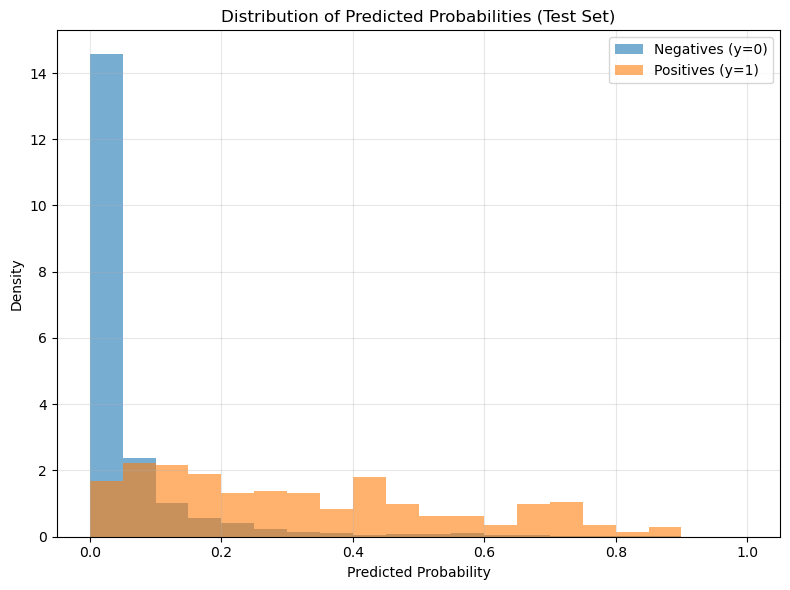

In [16]:
import matplotlib.pyplot as plt

# Checking our Model - Distribution of Predicted Probabilities: Positives & Negatives

# Masks for positives and negatives
pos_mask = (y_test == 1)
neg_mask = (y_test == 0)

pos_probs = test_probs[pos_mask]
neg_probs = test_probs[neg_mask]

print(f"Test positives (y=1): {pos_mask.sum():,}")
print(f"Test negatives (y=0): {neg_mask.sum():,}\n")

# Descriptive stats
print("--- Positives Only (y=1) ---")
print(pd.Series(pos_probs).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))

print("\n--- Negatives Only (y=0) ---")
print(pd.Series(neg_probs).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))

# Histogram for visual comparison
plt.figure(figsize=(8, 6))

# Define consistent bins for both plots so they align
my_bins = np.linspace(0, 1, 21)

plt.hist(neg_probs, bins=my_bins, alpha=0.6, density=True, label="Negatives (y=0)")
plt.hist(pos_probs, bins=my_bins, alpha=0.6, density=True, label="Positives (y=1)")

# Display histogram
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

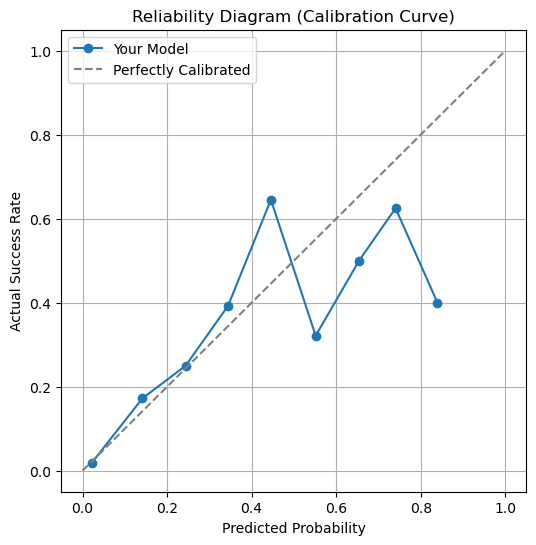

In [17]:
from sklearn.calibration import calibration_curve

# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(y_test, test_probs, n_bins=10)

# Plot it
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Success Rate')
plt.title('Reliability Diagram (Calibration Curve)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Compute GIZ over expected on Test Set (GIZ_over_expected = actual (0/1) - predicted_prob)

# Make a working copy of the test dataframe
test_results = test_df.copy()

# Ensure alignment: y_test should be in the same order as test_df
test_results["actual_giz"] = y_test.values
test_results["pred_prob_giz"] = test_probs

# GIZ over expected: positive = outperformed model expectation
test_results["giz_over_expected"] = test_results["actual_giz"] - test_results["pred_prob_giz"]


In [19]:
# Tables for 20 Best/Worst GIZ Over Expected Plays

# Recompute best / worst based on giz_over_expected
best_20 = test_results.sort_values("giz_over_expected", ascending=False).head(20)
worst_20 = test_results.sort_values("giz_over_expected", ascending=True).head(20)

# Only keep the requested columns
display_cols = [
    "player_name",
    "game_id",
    "play_id",
    "dist_to_ball",
    "tether_distance",
    "velocity_towards_ball",
    "team_coverage_man_zone",
    "ball_in_air_time",
    "actual_giz",
    "pred_prob_giz",
    "giz_over_expected",
    "angle_from_deep"
    
]
display_cols = [c for c in display_cols if c in test_results.columns]

# Nicer column names for display
col_rename_map = {
    "player_name": "Player Name",
    "dist_to_ball": "Dist to Ball (yds)",
    "velocity_towards_ball": "Vel Toward Ball (yd/s)",
    "ball_in_air_time": "Ball Air Time (s)",
    "actual_giz": "Actual (0/1)",
    "pred_prob_giz": "Predicted GIZ %",
    "giz_over_expected": "GIZ Over Expected",
    "tether_distance": "Tether Distance",
    "team_coverage_man_zone": "Coverage Type",
    "angle_from_deep": "Angle from ball to QB"
}

def make_pretty_table(df, title):
    # Restrict and rename columns
    df_disp = df[display_cols].rename(columns=col_rename_map).copy()
    
    # Use the index itself as Rank (1..N)
    df_disp = df_disp.reset_index(drop=True)
    df_disp.index = range(1, len(df_disp) + 1)
    df_disp.index.name = "Rank"
    
    # Numeric formatting
    format_dict = {
        "Dist to Ball (yds)": "{:.2f}",
        "Vel Toward Ball (yd/s)": "{:.2f}",
        "Accel Toward Ball (yd/s²)": "{:.2f}",
        "Ball Air Time (s)": "{:.2f}",
        "Predicted GIZ %": "{:.3f}",
        "GIZ Over Expected": "{:.3f}",
        "Actual (0/1)": "{:.0f}",
    }
    
    styler = df_disp.style.format(format_dict).set_caption(title)
    
    styler = styler.set_table_styles(
        [
            {
                "selector": "caption",
                "props": [
                    ("caption-side", "top"),
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                    ("text-align", "center"),
                    ("padding", "8px 0")
                ],
            },
            {
                "selector": "th",
                "props": [
                    ("background-color", "#1f4e79"),
                    ("color", "white"),
                    ("font-weight", "bold"),
                    ("padding", "6px 8px"),
                    ("text-align", "center")
                ],
            },
            {
                "selector": "td",
                "props": [
                    ("padding", "4px 8px"),
                    ("text-align", "center")
                ],
            },
        ]
    ).background_gradient(
        subset=["GIZ Over Expected"],
        cmap="RdYlGn"
    )
    
    return styler

# Build tables for best and worst 20 plays
best_table_styled = make_pretty_table(
    best_20,
    "Top 20 Best GIZ Over Expected (Outperformers)"
)

worst_table_styled = make_pretty_table(
    worst_20,
    "Top 20 Worst GIZ Over Expected (Underperformers)"
)

# Display in notebook
display(best_table_styled)
display(worst_table_styled)

,Player Name,game_id,play_id,Dist to Ball (yds),Vel Toward Ball (yd/s),Coverage Type,Ball Air Time (s),Actual (0/1),Predicted GIZ %,GIZ Over Expected,Angle from ball to QB
Rank,,,,,,,,,,,
1,Alontae Taylor,2023123109,2282,7.00,-5.36,ZONE_COVERAGE,1.00,1,0.000,1.000,100.601469
2,Drue Tranquill,2023123113,1170,4.26,-5.85,ZONE_COVERAGE,0.70,1,0.000,1.000,130.320037
3,Cobie Durant,2023122100,1210,7.82,-1.42,ZONE_COVERAGE,1.00,1,0.008,0.992,119.117094
4,A.J. Terrell,2024010700,3770,6.02,-2.21,ZONE_COVERAGE,1.00,1,0.016,0.984,112.343676
5,Krys Barnes,2023122409,810,11.45,1.98,ZONE_COVERAGE,1.30,1,0.020,0.980,149.532989
6,DeMarcco Hellams,2023122402,1310,4.72,-4.17,ZONE_COVERAGE,0.90,1,0.022,0.978,67.198628
7,Dane Belton,2023122501,3275,13.09,2.24,ZONE_COVERAGE,1.50,1,0.022,0.978,157.992985
8,Stephon Gilmore,2023123000,78,7.98,-0.47,ZONE_COVERAGE,1.10,1,0.023,0.977,128.947365
9,Patrick Queen,2024010600,1679,10.48,1.13,ZONE_COVERAGE,1.30,1,0.023,0.977,154.025062


,Player Name,game_id,play_id,Dist to Ball (yds),Vel Toward Ball (yd/s),Coverage Type,Ball Air Time (s),Actual (0/1),Predicted GIZ %,GIZ Over Expected,Angle from ball to QB
Rank,,,,,,,,,,,
1,Derek Stingley Jr.,2023122404,2313,2.46,1.65,ZONE_COVERAGE,2.10,0,0.874,-0.874,164.280266
2,Jason Taylor,2024010710,3357,12.76,6.77,ZONE_COVERAGE,2.30,0,0.854,-0.854,162.492273
3,Dennis Gardeck,2024010712,471,12.65,6.14,ZONE_COVERAGE,2.20,0,0.853,-0.853,165.028817
4,Deommodore Lenoir,2024010710,1532,1.45,5.04,ZONE_COVERAGE,0.80,0,0.853,-0.853,163.619584
5,Jaire Alexander,2024010706,2375,6.68,7.50,ZONE_COVERAGE,1.40,0,0.845,-0.845,179.477818
6,DeAndre Houston-Carson,2023122404,2042,23.01,7.39,ZONE_COVERAGE,2.90,0,0.825,-0.825,165.887236
7,Tariq Castro-Fields,2023123110,606,1.22,3.07,ZONE_COVERAGE,1.70,0,0.807,-0.807,145.565286
8,Brandon Stephens,2023122502,1113,6.13,7.21,ZONE_COVERAGE,1.50,0,0.801,-0.801,177.036782
9,Starling Thomas V,2023123108,1789,18.63,7.27,ZONE_COVERAGE,2.50,0,0.801,-0.801,169.442985


--- Computing Feature Importance  ---


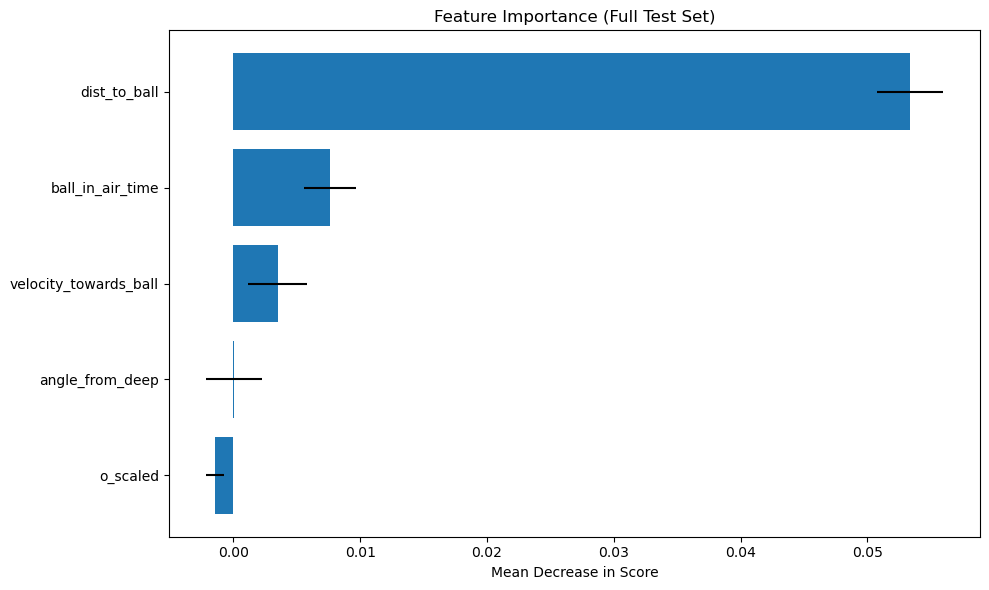

In [22]:
from sklearn.inspection import permutation_importance


# Feature Importance Plot

print("--- Computing Feature Importance  ---")

# 1. Run Permutation Importance on the full test set
result = permutation_importance(
    final_model, 
    X_test, 
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 2. Extract raw importance scores
importances_mean = result.importances_mean
importances_std = result.importances_std

filtered_features = np.array([features[i] for i in keep_indices])
filtered_mean = importances_mean[keep_indices]
filtered_std = importances_std[keep_indices]

# 4. Sort the remaining features by importance (descending)
sorted_idx = np.argsort(filtered_mean)[::-1]
sorted_features = filtered_features[sorted_idx]
sorted_mean = filtered_mean[sorted_idx]
sorted_std = filtered_std[sorted_idx]

# 5. Plot our Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_mean, xerr=sorted_std, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Mean Decrease in Score")
plt.title("Feature Importance (Full Test Set)")
plt.tight_layout()
plt.show()

In [23]:
from IPython.display import display
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# Display Top 20 and Bottom 20 Defenders

# 1. Generate Unbiased Predictions (Out-Of-Fold)
print("--- Generating Fair Leaderboard Stats ---")

cols_to_check = ['target_made_zone', 'nfl_id', 'player_name']
full_season_df = modeling_df.dropna(subset=cols_to_check).copy()

# Define out-of-fold strategy (We use the 'final_model' as a template (same parameters/physics rules), 
# but cross_val_predict will retrain it 5 times on different folds.)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running Out-of-Fold Predictions (this may take 1-2 mins)...")
# This ensures every single play is predicted by a model that did not see that play during training.
cv_probs = cross_val_predict(
    final_model, 
    full_season_df[features], 
    full_season_df['target_made_zone'], 
    cv=cv_strategy, 
    method='predict_proba', 
    n_jobs=-1
)[:, 1]

# Assign these fair probabilities
full_season_df['pred_prob'] = cv_probs
full_season_df['giz_oe'] = full_season_df['target_made_zone'] - full_season_df['pred_prob']

print("Predictions Complete.")


# 2. Aggregate Stats & Bayesian Shrinkage

# A. Aggregation
aggs = {
    'giz_oe': ['count', 'mean', 'var'],
    'target_made_zone': 'sum'  # Sum of 1s = True Positives
}

player_stats = full_season_df.groupby(['nfl_id', 'player_name']).agg(aggs).reset_index()

# Flatten MultiIndex columns
player_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in player_stats.columns.values]

# Rename columns
player_stats = player_stats.rename(columns={
    'giz_oe_count': 'Plays',
    'giz_oe_mean': 'Raw_Avg_OE',
    'giz_oe_var': 'var',
    'target_made_zone_sum': 'True_Positives'
})

# Calculate True Negatives
player_stats['True_Negatives'] = player_stats['Plays'] - player_stats['True_Positives']

# Fill NaN variance with global variance
player_stats['var'] = player_stats['var'].fillna(full_season_df['giz_oe'].var())

# B. Perform Bayesian Shrinkage
global_mean = full_season_df['giz_oe'].mean()
sigma2_noise = player_stats['var'].mean()
obs_var_means = player_stats['Raw_Avg_OE'].var()
avg_sample_size = player_stats['Plays'].mean()
sigma2_signal = max(0, obs_var_means - (sigma2_noise / avg_sample_size))

player_stats['weight'] = sigma2_signal / (sigma2_signal + (sigma2_noise / player_stats['Plays']))
player_stats['GIZ_Score'] = global_mean + player_stats['weight'] * (player_stats['Raw_Avg_OE'] - global_mean)

# C. Filtering
# Only players with MORE THAN 52 plays
filtered_df = player_stats[player_stats['Plays'] > 52].copy()
filtered_df = filtered_df.sort_values('GIZ_Score', ascending=False).reset_index(drop=True)
filtered_df['Rank'] = filtered_df.index + 1


# 3. Create Tables

display_cols = ['Rank', 'player_name', 'Plays', 'True_Positives', 'True_Negatives', 'Raw_Avg_OE', 'GIZ_Score']
rename_map = {
    'player_name': 'Player', 
    'True_Positives': 'Made Zone',
    'True_Negatives': 'Missed Zone',
    'Raw_Avg_OE': 'Raw OE', 
    'GIZ_Score': 'GIZ Score'
}

def create_styled_table(df, title, cmap='Blues'):
    return (df[display_cols].rename(columns=rename_map)
            .style
            .format({
                'Made Zone': '{:.0f}',
                'Missed Zone': '{:.0f}',
                'Raw OE': '{:+.3f}',
                'GIZ Score': '{:+.3f}'
            })
            .background_gradient(subset=['GIZ Score'], cmap=cmap)
            .set_caption(title)
            .set_table_styles([
                {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
                {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold')]}
            ])
            .hide(axis='index'))

# Display Tables
print("\n--- Displaying Top 20 Defenders (Fair, Out-of-Fold) ---")
display(create_styled_table(filtered_df.head(20), "Top 20 Defenders by GIZ Score", cmap='Greens'))

print("\n--- Displaying Bottom 20 Defenders (Fair, Out-of-Fold) ---")
display(create_styled_table(filtered_df.tail(20), "Bottom 20 Defenders by GIZ Score", cmap='Reds_r'))

# 4. Probability Context (Top 5 vs Bottom 5)

print("\n" + "="*60)
print("CONTEXTUAL STATS: PREDICTED PROBABILITIES (Top 5 vs Bottom 5)")
print("="*60)

# Get IDs for top 5 and bottom 5
top_5_ids = filtered_df.head(5)['nfl_id'].unique()
bot_5_ids = filtered_df.tail(5)['nfl_id'].unique()

context_df = full_season_df[full_season_df['nfl_id'].isin(np.concatenate([top_5_ids, bot_5_ids]))].copy()

context_df['Group'] = context_df['nfl_id'].apply(lambda x: 'Top 5' if x in top_5_ids else 'Bottom 5')

prob_stats = context_df.groupby(['Group', 'player_name'])['pred_prob'].describe(
    percentiles=[0.25, 0.5, 0.75]
).reset_index()

prob_stats = prob_stats.sort_values(['Group', 'mean'], ascending=[False, True])

# Choose which stats to display for top and bottom 5 and display these stats
stats_display = (prob_stats[['Group', 'player_name', 'count', 'mean', 'min', '50%', 'max']]
                 .rename(columns={'player_name': 'Player', 'mean': 'Mean Prob', '50%': 'Median Prob'})
                 .style
                 .format({'Mean Prob': '{:.3f}', 'Median Prob': '{:.3f}', 'min': '{:.3f}', 'max': '{:.3f}'})
                 .bar(subset=['Mean Prob'], color='#d65f5f', vmin=0, vmax=1)
                 .set_caption("Predicted Probability Stats (Did they face easy or hard plays?)")
                 .hide(axis='index'))

display(stats_display)

--- Generating Fair Leaderboard Stats ---
Running Out-of-Fold Predictions (this may take 1-2 mins)...
Predictions Complete.

--- Displaying Top 20 Defenders (Fair, Out-of-Fold) ---


Rank,Player,Plays,Made Zone,Missed Zone,Raw OE,GIZ Score
1,Darius Slay,79,14,65,+0.090,+0.079
2,Darious Williams,106,18,88,+0.079,+0.071
3,Antoine Winfield Jr.,84,14,70,+0.074,+0.064
4,David Long Jr.,76,11,65,+0.070,+0.060
5,Zyon McCollum,75,12,63,+0.068,+0.059
6,Roquan Smith,133,19,114,+0.062,+0.057
7,Jaylon Johnson,63,11,52,+0.065,+0.055
8,Andre Cisco,76,8,68,+0.061,+0.053
9,Cam Taylor-Britt,66,12,54,+0.059,+0.050
10,C.J. Mosley,90,11,79,+0.052,+0.046



--- Displaying Bottom 20 Defenders (Fair, Out-of-Fold) ---


Rank,Player,Plays,Made Zone,Missed Zone,Raw OE,GIZ Score
166,Ja'Quan McMillian,72,5,67,-0.038,-0.032
167,Bobby Wagner,117,1,116,-0.037,-0.034
168,Roger McCreary,70,5,65,-0.041,-0.035
169,Troy Hill,64,3,61,-0.042,-0.035
170,Benjamin St-Juste,104,9,95,-0.039,-0.035
171,Michael Hoecht,56,3,53,-0.044,-0.036
172,Jaylon Jones,71,7,64,-0.044,-0.038
173,Divine Deablo,66,0,66,-0.045,-0.038
174,Brandon Stephens,107,8,99,-0.044,-0.040
175,DJ Turner II,66,6,60,-0.047,-0.040



CONTEXTUAL STATS: PREDICTED PROBABILITIES (Top 5 vs Bottom 5)


Group,Player,count,Mean Prob,min,Median Prob,max
Top 5,David Long Jr.,76.000000,0.075,0.001,0.021,0.532
Top 5,Darius Slay,79.000000,0.087,0.000,0.015,0.594
Top 5,Darious Williams,106.000000,0.091,0.000,0.030,0.832
Top 5,Zyon McCollum,75.000000,0.092,0.000,0.029,0.644
Top 5,Antoine Winfield Jr.,84.000000,0.093,0.000,0.023,0.741
Bottom 5,Jevon Holland,63.000000,0.059,0.000,0.008,0.685
Bottom 5,Demario Davis,90.000000,0.064,0.000,0.016,0.750
Bottom 5,Micah Hyde,67.000000,0.083,0.000,0.020,0.861
Bottom 5,Myles Bryant,69.000000,0.105,0.000,0.025,0.757
Bottom 5,Deommodore Lenoir,96.000000,0.116,0.000,0.033,0.880


In [24]:
# Check Mean GIZ Scores

# 1. Calculate the average GIZ Score across all qualified players
mean_giz = filtered_df['GIZ_Score'].mean()
print(f"Mean GIZ Score (Qualified Players): {mean_giz:.4f}")

# 2. See the full distribution (Min, Max, Median)
print("\n--- GIZ Score Distribution ---")
print(filtered_df['GIZ_Score'].describe().round(4))

Mean GIZ Score (Qualified Players): 0.0026

--- GIZ Score Distribution ---
count    185.0000
mean       0.0026
std        0.0266
min       -0.0575
25%       -0.0146
50%        0.0038
75%        0.0213
max        0.0786
Name: GIZ_Score, dtype: float64


In [25]:
# Player Deep Dive: Top 5 Players (Best & Worst Plays)

# 1. Get the Top 5 Players from the previously filtered list
top_5_players = filtered_df.head(5).copy()
top_5_ids = top_5_players['nfl_id'].tolist()

# 2. Define columns to see for the specific plays
play_cols = [
    'week', 
    'quarter', 
    'down', 
    'yards_togo', 
    'play_description',
    'target_made_zone', 
    'pred_prob', 
    'giz_oe'
]

# Filter columns to only those that actually exist in the dataframe to prevent errors
existing_cols = [c for c in play_cols if c in full_season_df.columns]

play_highlights = []

for pid in top_5_ids:
    # Get player metadata
    p_rank = top_5_players.loc[top_5_players['nfl_id'] == pid, 'Rank'].values[0]
    p_name = top_5_players.loc[top_5_players['nfl_id'] == pid, 'player_name'].values[0]
    
    # Get all plays for this player
    p_plays = full_season_df[full_season_df['nfl_id'] == pid].copy()
    
    # Sort by GIZ OE (Descending)
    p_plays = p_plays.sort_values('giz_oe', ascending=False)
    
    # Extract Top 3 (Best)
    top_3 = p_plays.head(3).copy()
    top_3['Play Type'] = ['Best #1', 'Best #2', 'Best #3']
    
    # Extract Bottom 3 (Worst) - Sort ascending to get the absolute lowest
    bot_3 = p_plays.tail(3).sort_values('giz_oe', ascending=True).copy()
    bot_3['Play Type'] = ['Worst #1', 'Worst #2', 'Worst #3']
    
    # Combine
    combined = pd.concat([top_3, bot_3])
    combined['Player'] = f"#{p_rank} {p_name}" # Combine Rank and Name for the header
    
    play_highlights.append(combined)

# Create the final dataframe
highlights_df = pd.concat(play_highlights)

# Organize columns: Player and Play Type first, then stats
final_cols = ['Player', 'Play Type'] + existing_cols
highlights_df = highlights_df[final_cols]

# 4. Display Table

def style_highlights(df):
    return (df.style
            .format({
                'giz_oe': '{:+.3f}',
                'pred_prob': '{:.1%}',
                'target_made_zone': '{:.0f}'
            })
            # Color code the OE: Green for high (good), Red for low (bad)
            .background_gradient(subset=['giz_oe'], cmap='RdYlGn', vmin=-1, vmax=1)
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#404040'), 
                                             ('color', 'white'), 
                                             ('font-weight', 'bold')]},
                {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                  ('font-weight', 'bold'), 
                                                  ('margin-bottom', '10px')]}
            ])
            .set_caption("Deep Dive: Top 5 Defenders' Best & Worst Plays")
            .hide(axis='index')
            .set_properties(**{'border-bottom': '1px solid #ccc'})
           )

print("\n--- Displaying Top 5 Player Deep Dive ---")
display(style_highlights(highlights_df))


--- Displaying Top 5 Player Deep Dive ---


Player,Play Type,week,target_made_zone,pred_prob,giz_oe
#1 Darius Slay,Best #1,3,1,0.6%,+0.994
#1 Darius Slay,Best #2,5,1,3.5%,+0.965
#1 Darius Slay,Best #3,11,1,8.4%,+0.916
#1 Darius Slay,Worst #1,1,0,37.4%,-0.374
#1 Darius Slay,Worst #2,7,0,27.6%,-0.276
#1 Darius Slay,Worst #3,8,0,24.9%,-0.249
#2 Darious Williams,Best #1,1,1,3.1%,+0.969
#2 Darious Williams,Best #2,8,1,4.7%,+0.953
#2 Darious Williams,Best #3,6,1,4.8%,+0.952
#2 Darious Williams,Worst #1,5,0,83.2%,-0.832


In [26]:
# Player Deep Dive: Bottom Five Players (Best & Worst Plays)


# 1. Get the Bottom 5 Players
bottom_5_players = filtered_df.tail(5).iloc[::-1].copy()
bottom_5_ids = bottom_5_players['nfl_id'].tolist()

# 2. Define columns (Same as before)
play_cols = [
    'week',
    'quarter',
    'down',
    'yards_togo',
    'play_description',
    'target_made_zone',
    'pred_prob',
    'giz_oe'
]

existing_cols = [c for c in play_cols if c in full_season_df.columns]

play_highlights_bottom = []

for pid in bottom_5_ids:
    # Get player metadata
    p_rank = bottom_5_players.loc[bottom_5_players['nfl_id'] == pid, 'Rank'].values[0]
    p_name = bottom_5_players.loc[bottom_5_players['nfl_id'] == pid, 'player_name'].values[0]

    # Get all plays for this player
    p_plays = full_season_df[full_season_df['nfl_id'] == pid].copy()

    # Sort by GIZ OE (Descending) to easily grab top and bottom
    p_plays = p_plays.sort_values('giz_oe', ascending=False)

    # Extract Top 3 (Best moments for this player)
    top_3 = p_plays.head(3).copy()
    top_3['Play Type'] = ['Best #1', 'Best #2', 'Best #3']

    # Extract Bottom 3 (Worst moments for this player)
    bot_3 = p_plays.tail(3).sort_values('giz_oe', ascending=True).copy()
    bot_3['Play Type'] = ['Worst #1', 'Worst #2', 'Worst #3']

    # Combine
    combined = pd.concat([top_3, bot_3])
    combined['Player'] = f"#{p_rank} {p_name}"

    play_highlights_bottom.append(combined)

# Create the final dataframe
highlights_bottom_df = pd.concat(play_highlights_bottom)

# Organize columns
final_cols = ['Player', 'Play Type'] + existing_cols
highlights_bottom_df = highlights_bottom_df[final_cols]

# Display Table (Bottom 5)

def style_highlights_bottom(df):
    return (df.style
            .format({
                'giz_oe': '{:+.3f}',
                'pred_prob': '{:.1%}',
                'target_made_zone': '{:.0f}'
            })
            # Color code: Green (Good), Red (Bad)
            .background_gradient(subset=['giz_oe'], cmap='RdYlGn', vmin=-1, vmax=1)
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#404040'),
                                             ('color', 'white'),
                                             ('font-weight', 'bold')]},
                {'selector': 'caption', 'props': [('font-size', '16px'),
                                                  ('font-weight', 'bold'),
                                                  ('margin-bottom', '10px')]}
            ])
            .set_caption("Deep Dive: Bottom 5 Defenders' Best & Worst Plays")
            .hide(axis='index')
            .set_properties(**{'border-bottom': '1px solid #ccc'})
           )

print("\n--- Displaying Bottom 5 Player Deep Dive ---")
display(style_highlights_bottom(highlights_bottom_df))


--- Displaying Bottom 5 Player Deep Dive ---


Player,Play Type,week,target_made_zone,pred_prob,giz_oe
#185 Micah Hyde,Best #1,3,1,54.9%,+0.451
#185 Micah Hyde,Best #2,18,0,0.0%,-0.000
#185 Micah Hyde,Best #3,17,0,0.0%,-0.000
#185 Micah Hyde,Worst #1,9,0,86.1%,-0.861
#185 Micah Hyde,Worst #2,4,0,72.2%,-0.722
#185 Micah Hyde,Worst #3,17,0,64.6%,-0.646
#184 Deommodore Lenoir,Best #1,17,1,7.7%,+0.923
#184 Deommodore Lenoir,Best #2,11,1,17.2%,+0.828
#184 Deommodore Lenoir,Best #3,5,1,38.7%,+0.613
#184 Deommodore Lenoir,Worst #1,2,0,88.0%,-0.880
